## Requirements

In [1]:
# Import all required libraries
import yfinance as yf
import numpy as np
i = complex(0,1)
np.random.seed(8309)

# Import all functions from custom modules
from Load_data_yfiance import get_Today_data, save_to_csv, read_from_csv
from plot_loc_vol_surface import plot_local_vol_surface
from heston import heston_simulation, fit_Heston_model
from garch import Garch_simulation,get_param_garch
from dupire import dupire_local_vol, dupire_simulation, get_spline
from BaseLineGBM import GBM_simulation
from plot_result import plot_s_paths,plot_v_paths,plot_log_norm,plot_CI,plot_sharkfin,valuation
from greeks import plot_greeks
from Fit_interp_regres import get_interp
from plot_2_interp import plot_two_interp

## Load Data

In [2]:
ticker = "^SPX"
spx = yf.Ticker(ticker)
r = 0.045

calls,date = get_Today_data(Ticker = spx, r = r)
save_to_csv(calls,date)
# calls = read_from_csv("2025-10-28")
print("range of strike: ",calls["strike"].min(),calls["strike"].max())
print("range of Moneyness: ",calls["y"].min(),calls["y"].max())
print("range of ttm: ",calls["ttm"].min(),calls["ttm"].max())
print("number of options: ",calls.size)
calls.head()

range of strike:  5110.0 7085.0
range of Moneyness:  -0.27645003205600344 0.053736595221213
range of ttm:  0.011904761904761904 1.3611111111111112
number of options:  52035


,strike,lastPrice,lastTradeDate,CP,exp,S0,ttm,exp_month,r,in_out,F,q,imp_vol,w,y
3244,5110.0,1757.40,2025-10-31 14:09:01+00:00,0,2025-11-28,6728.799805,0.083333,2511,0.045,in,6737.233874,0.029968,0.926672,0.071560,-0.276450
3246,5170.0,1706.23,2025-10-31 19:46:54+00:00,0,2025-11-28,6728.799805,0.083333,2511,0.045,in,6737.233874,0.029968,0.920268,0.070574,-0.264777
2186,5175.0,1639.26,2025-10-24 18:50:49+00:00,0,2025-11-21,6728.799805,0.055556,2511,0.045,in,6737.233874,0.022452,0.936391,0.048713,-0.263810
1810,5200.0,1555.00,2025-10-20 20:13:38+00:00,0,2025-11-19,6728.799805,0.047619,2511,0.045,in,6737.233874,0.018694,0.688555,0.022577,-0.258991
3249,5250.0,1617.08,2025-10-30 15:55:29+00:00,0,2025-11-28,6728.799805,0.083333,2511,0.045,in,6737.233874,0.029968,0.859783,0.061602,-0.249421


In [3]:
intrep,reg = get_interp(calls)
plot_two_interp(intrep,reg,calls)

# Methods

## Base Line: Constant Vol GBM

In [4]:
spx = yf.download(ticker, period='31d')
spx['returns'] = np.log(spx['Close'] / spx['Close'].shift(1))
vol = spx['returns'].dropna().std()
vol_annual = vol * np.sqrt(252)
mu = spx['returns'].dropna().mean()
mu_annual = mu * 252
print("Annualized 30-days Mean:",mu_annual)
print("Annualized 30-days Volatility:",vol_annual)

[*********************100%***********************]  1 of 1 completed

Annualized 30-days Mean: 0.10691289866852047
Annualized 30-days Volatility: 0.13055478803884724


## Local Volitality Method

### Get Interpolation and Regression (as comparison)

In [5]:
spline = get_spline(calls)
local_vol_surface = dupire_local_vol(calls,spline)
plot_local_vol_surface(calls,local_vol_surface)

## Heston Method

In [6]:
v0,kappa,theta,rho,sigma = fit_Heston_model(calls)
print("initial variance under risk-neutral dynamics")
print("v0:", v0)
print("rate of mean reversion of variance under risk-neutral dynamics")
print("kappa:", kappa)
print("long-term mean of variance under risk-neutral dynamics")
print("theta:", theta)
print("correlation between returns and variances under risk-neutral dynamics")
print("rho:", rho)
print("volatility of volatility")
print("sigma:", sigma)

initial variance under risk-neutral dynamics
v0: 0.027725232461220706
rate of mean reversion of variance under risk-neutral dynamics
kappa: 1.9819642107566076
long-term mean of variance under risk-neutral dynamics
theta: 0.028837541148032827
correlation between returns and variances under risk-neutral dynamics
rho: -0.5045089495653229
volatility of volatility
sigma: 0.028837541148032827


## Garch Method

In [7]:
omega, alpha, beta = get_param_garch(ticker)
print("Omega:",omega)
print("Alpha:",alpha)
print("Beta:",beta)

[*********************100%***********************]  1 of 1 completed

Omega: 7.983814109427158e-06
Alpha: 0.04999999831833821
Beta: 0.899999999547471


# Path Simulated And Results Comparison

## Set Up parameters

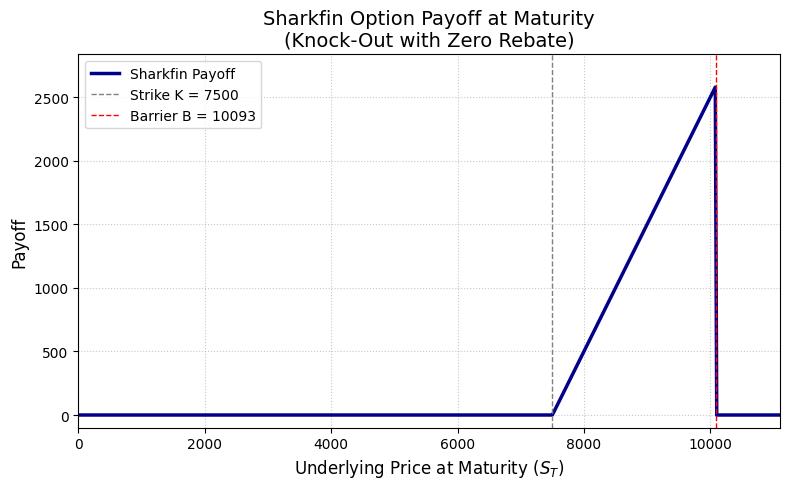

In [8]:
# Exercise price
K = 7500
# time in years
T = 0.5
# number of time steps in simulation
N = int(T*252)
# asset price
S0 = calls["S0"].iloc[0]
# risk-free rate
r = calls["r"].iloc[0]
# Divident rate
q = 0
# number of simulations
M = 100000
# Knock-out barrier
B = 1.5*S0
plot_sharkfin(B,K)


## Plot Paths

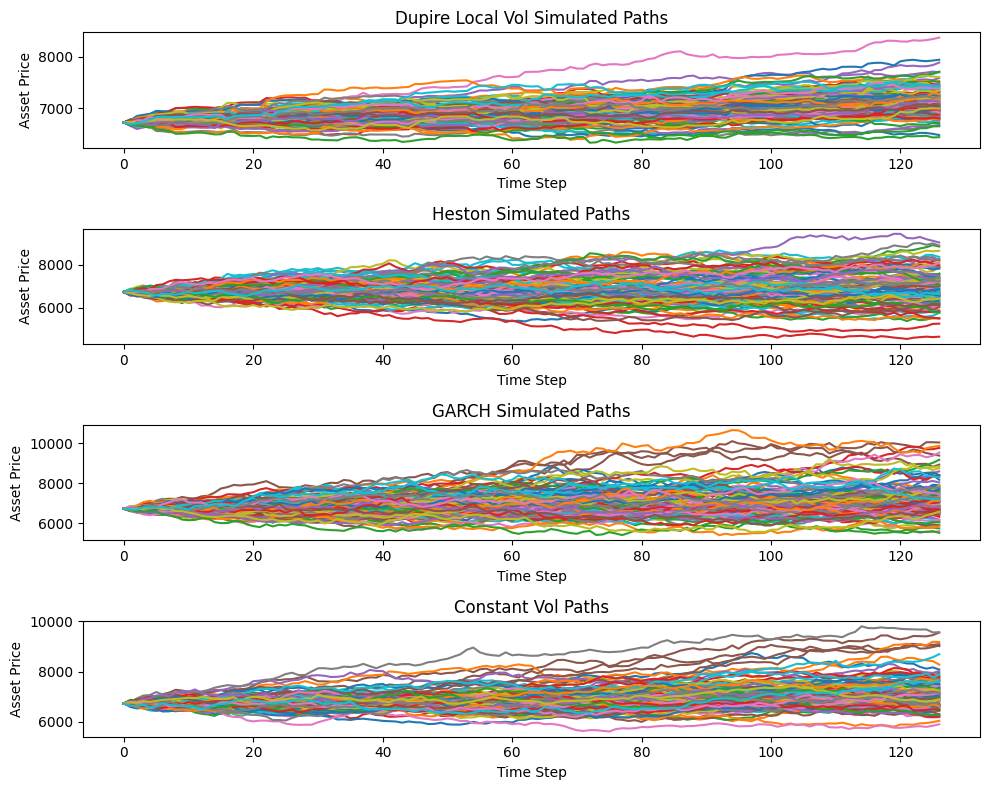

In [9]:
S_path_Heston,V_path_Heston = heston_simulation(S0=S0,r=r,q=q,K=K,T=T,v0=v0,kappa=kappa,theta=theta,rho=rho,sigma=sigma,M=M,N=N)
S_path_dupire,V_path_dupire = dupire_simulation(mu_annual=mu_annual,K=K,S0=S0,T=T,N=N,M=M, calls = calls, spline=spline)
# S_path_dupire,V_path_dupire = np.zeros((N+1,M)),np.zeros((N+1,))
S_path_Garch, V_path_Garch = Garch_simulation(omega=omega, alpha=alpha, beta=beta,mu_annual=mu_annual,vol_annual=vol_annual,N=N,M=M,S0=S0,T=T)
S_path_GBM, V_path_GBM = GBM_simulation(vol_annual=vol_annual,mu_annual=mu_annual,S0=S0,T=T,N=N,M=M)

plot_s_paths(S_path_dupire,S_path_Heston,S_path_Garch,S_path_GBM,m=100)


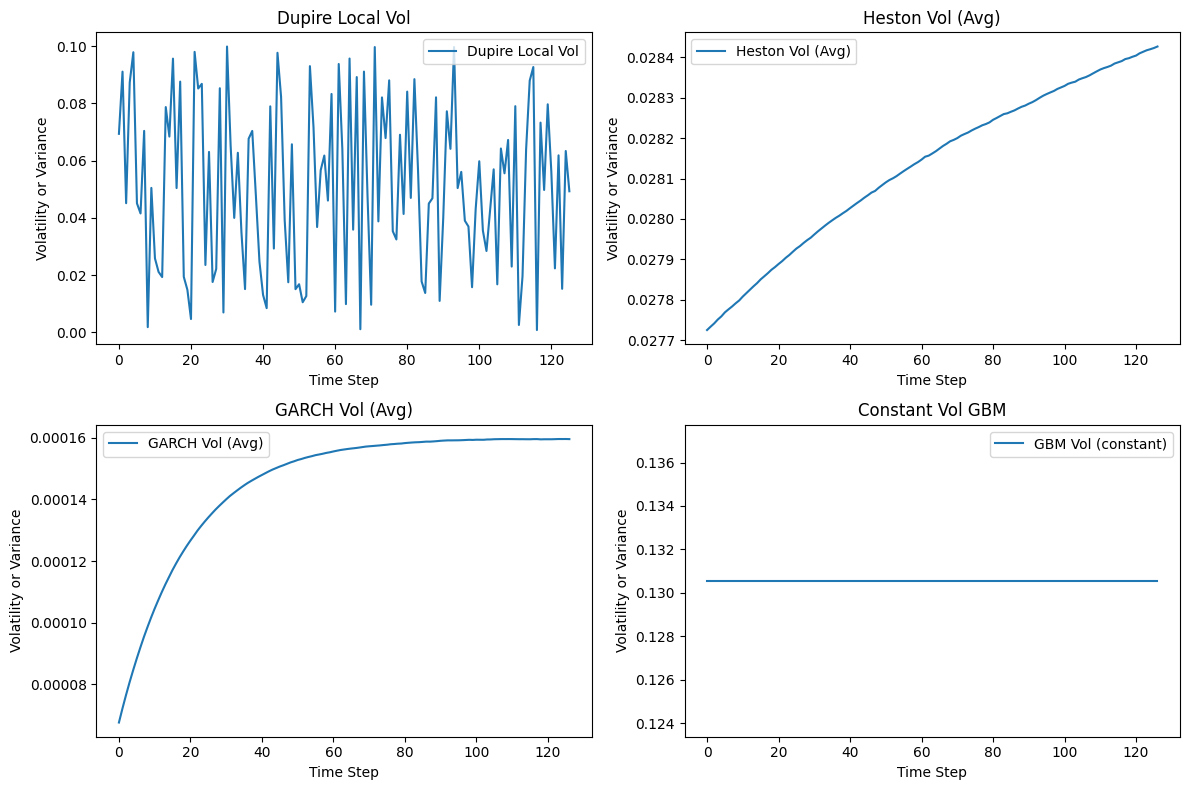

In [10]:
plot_v_paths(V_path_dupire,V_path_Heston,V_path_Garch,V_path_GBM)

## Plot PAYOFF Distribution

In [11]:
local_vol_value = valuation(S_path_dupire,K,B,r,AMR=True)
heston_value = valuation(S_path_Heston,K,B,r,AMR=True)
Garch_Vol_value = valuation(S_path_Garch,K,B,r,AMR=True)
Constant_vol_value = valuation(S_path_GBM,K,B,r,AMR=True)

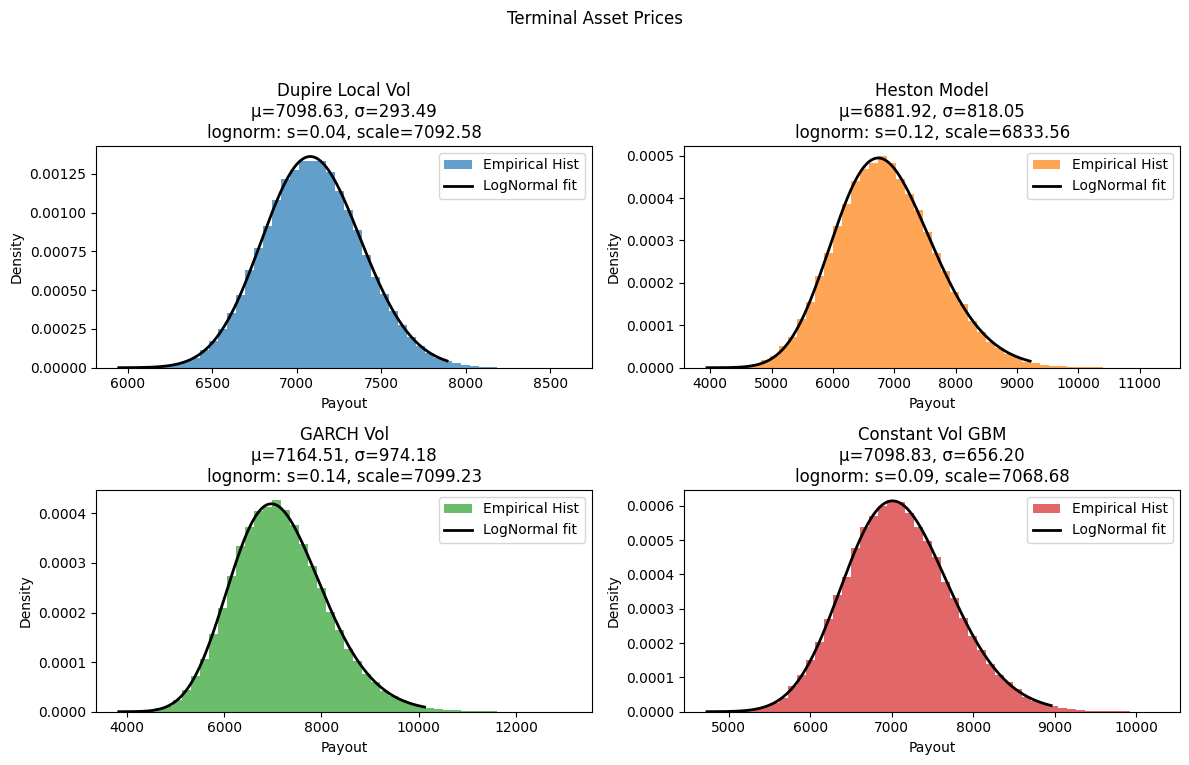

In [12]:
plot_log_norm(S_path_dupire[-1,:],S_path_Heston[-1,:],S_path_Garch[-1,:],S_path_GBM[-1,:],'Terminal Asset Prices',dist = True)

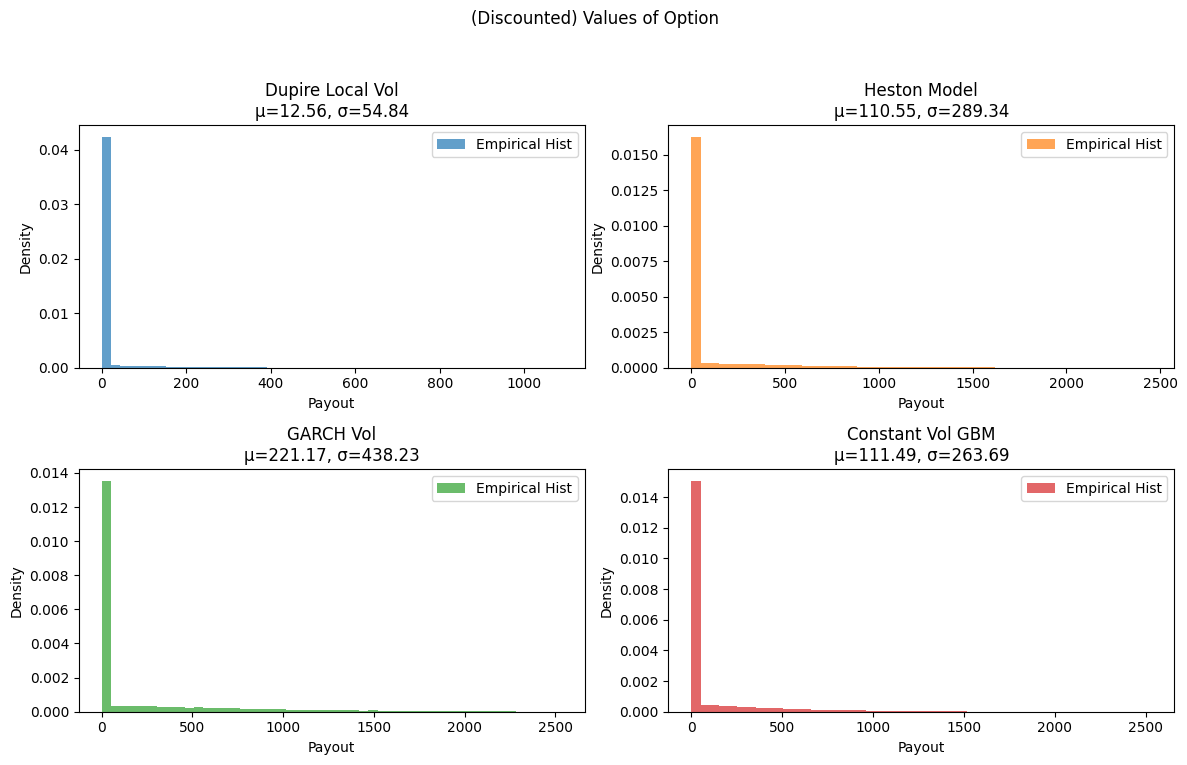

In [13]:
plot_log_norm(local_vol_value,heston_value,Garch_Vol_value,Constant_vol_value,'(Discounted) Values of Option',dist = False)

## Test: Are Values statistically significently different

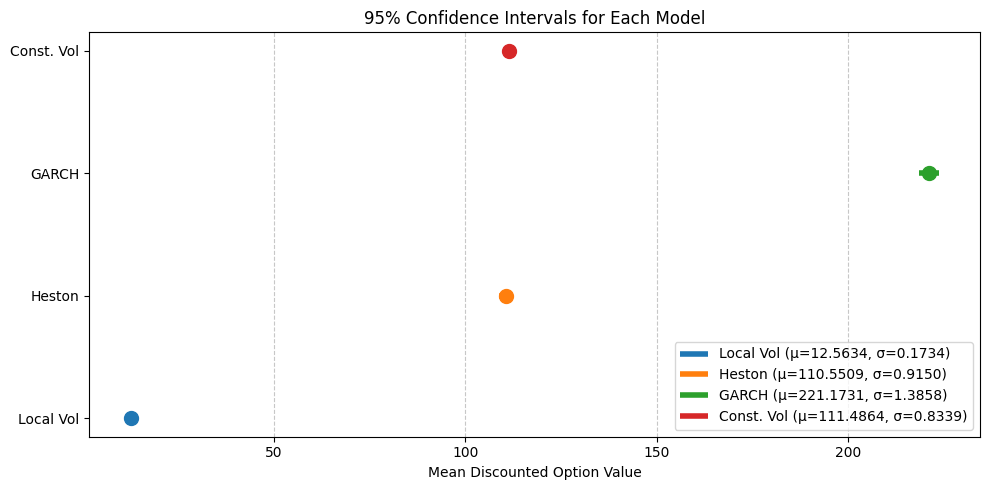

In [14]:
plot_CI(local_vol_value,heston_value,Garch_Vol_value,Constant_vol_value,alpha = 0.05)


# Greeks by Monte Carlo Simulation

In [15]:
plot_greeks(r=r, sigma=vol_annual, K=K, B=B, S0=S0, h=1, vol_h=0.005, n_sim=100000)

KeyboardInterrupt: 